In [ ]:
!pip install --upgrade pip
!pip install "snowflake-connector-python[pandas]" "snowflake-snowpark-python[pandas]" snowflake-snowpark-python==1.9.0 numpy pandas matplotlib scikit-learn xgboost seaborn python-dateutil tqdm holidays faker
!pip install --upgrade --q snowflake-snowpark-python==1.9.0
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15
!pip install fosforml==1.1.6
!pip install yellowbrick

In [1]:
from fosforml import *
from fosforml.constants import MLModelFlavours
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import warnings; warnings.simplefilter('ignore')
from joblib import dump, load
import requests
from tqdm import tqdm
import time
import calendar

from time import sleep
import configparser
from dateutil.relativedelta import relativedelta
import datetime
from dateutil.easter import easter
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit

%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Configure the font family to avoid 'sans-serif' warnings
rcParams['font.family'] = 'DejaVu Sans'  # or another available font on your system


In [3]:
#Importing the Libraries

import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [4]:
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()

In [5]:
cust_df = pd.read_csv('customer_table.csv')
cust_df

,PLAYER_ID,AGE,GENDER,HOME_COUNTRY,HOME_CITY,DATE_FIRST_VISIT,DATE_LAST_VISIT,TOTAL_NUMBER_OF_VISITS,TOTAL_DURATION_SPENT,AVERAGE_DURATION_PER_VISIT,TOTAL_CHIPS_WON_OR_LOST,AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT,UNIQUE_GAMES_PLAYED,IS_PREMIUM_PLAYER,IS_LOYALTY_CARD_HOLDER,TOTAL_AMOUNT_SPENT_IN_HOTEL,TOTAL_DAYS_SPENT_HOTEL,TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT,NUMBER_OF_RESTAURANT_VISITS,TOTAL_AMOUNT_SPENT_IN_SPA,NUMBER_OF_SPA_VISITS,TOTAL_REVENUE_TO_CASINO,NUMBER_OF_CONCIERGE_VISITS,PREFERRED_GAME_CATEGORY,PREFERRED_GAME_NAME
0,1,28,Female,India,Hyderabad,02-10-2021,19-08-2024,24,111.17,4.632083,4048,168.666667,8,False,True,26043.68,181,5634.89,111,11490.81,51,39121.38,96,Slot games,Video Slots
1,2,69,Female,Singapore,Singapore,06-09-2021,17-08-2024,24,114.26,4.760833,-2159,-89.958333,10,True,False,28966.09,207,7598.32,105,14077.87,50,52801.28,102,Slot games,3D Slots
2,3,52,Female,Singapore,Singapore,27-11-2021,22-06-2024,17,81.23,4.778235,-419,-24.647059,9,False,False,23593.94,109,4642.91,96,10904.30,35,39560.15,66,Table games,Roulette
3,4,41,Female,India,Delhi,10-10-2021,18-05-2024,17,69.72,4.101176,-246,-14.470588,9,True,False,23461.30,86,5322.28,85,6804.14,36,35833.72,78,Table games,Roulette
4,5,66,Female,UK,Manchester,08-09-2021,01-08-2024,15,70.89,4.726000,-755,-50.333333,8,True,True,24073.65,141,4136.14,63,7313.53,31,36278.32,82,Table games,Poker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,29,Male,Singapore,Singapore,11-09-2021,30-08-2024,28,119.51,4.268214,-441,-15.750000,11,True,True,24560.35,129,7388.70,166,11911.56,62,44301.61,138,Speciality Number Games,Keno
9996,9997,47,Female,Singapore,Singapore,19-10-2021,28-07-2024,19,102.57,5.398421,1089,57.315789,9,False,False,21510.39,122,5016.20,98,8048.02,37,33485.61,84,Slot games,Video Slots
9997,9998,55,Female,US,Los Angeles,30-09-2021,09-07-2024,19,79.72,4.195789,-1700,-89.473684,11,False,True,31041.60,194,4244.95,101,10212.66,33,47199.21,82,Table games,Craps
9998,9999,51,Male,US,San Jose,11-09-2021,26-08-2024,17,64.82,3.812941,-1995,-117.352941,8,True,True,18119.32,166,4530.26,75,9866.26,29,34510.84,83,Table games,Roulette


In [6]:
t1_df = pd.read_csv('trx_1.csv')
t2_df = pd.read_csv('trx_2.csv')
t3_df = pd.read_csv('trx_3.csv')

In [ ]:
cust_sfdf = my_session.createDataFrame(cust_df)
cust_sfdf.write.mode("overwrite").save_as_table("casino_customers")

In [7]:
inter_df = t1_df._append(t2_df,ignore_index=True)
trx_df = inter_df._append(t3_df, ignore_index=True)
trx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 24 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   TRANSACTION_ID                      200000 non-null  int64  
 1   DATE                                200000 non-null  object 
 2   PLAYER_ID                           200000 non-null  int64  
 3   PLAYER_AGE                          200000 non-null  int64  
 4   PLAYER_GENDER                       200000 non-null  object 
 5   HOME_COUNTRY                        200000 non-null  object 
 6   HOME_CITY                           200000 non-null  object 
 7   GAME_CATEGORY                       200000 non-null  object 
 8   GAME_NAME                           200000 non-null  object 
 9   TABLE_MINIMUM_BET                   200000 non-null  float64
 10  IS_PREMIUM_PLAYER                   200000 non-null  bool   
 11  DURATION_SPENT            

In [ ]:
trx_sfdf = my_session.createDataFrame(trx_df)
trx_sfdf.write.mode("overwrite").save_as_table("casino_transactions")

# Reading data from SF

In [8]:
# table_name = 'CASINO_TRANSACTIONS'
# transaction_df = my_session.sql("select * from {}".format(table_name))
# transaction_df = transaction_df.to_pandas()
# type(transaction_df)

transaction_df = trx_df.copy()
transaction_df.columns = [col.upper() for col in transaction_df.columns]




In [9]:
customer_aggregation = transaction_df.groupby('PLAYER_ID').agg(
    DATE_FIRST_VISIT=('DATE', 'min'),
    DATE_LAST_VISIT= ('DATE', 'max'),
    TOTAL_NUMBER_OF_VISITS=('TRANSACTION_ID', 'count'),
    TOTAL_DURATION_SPENT=('DURATION_SPENT', 'sum'),
    AVERAGE_DURATION_PER_VISIT=('DURATION_SPENT', 'mean'),
    TOTAL_CHIPS_WON_OR_LOST=('CHIPS_WON_OR_LOST', 'sum'),
    AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT=('CHIPS_WON_OR_LOST', 'mean'),
    UNIQUE_GAMES_PLAYED=('GAME_NAME', 'nunique'),
    IS_PREMIUM_PLAYER=('IS_PREMIUM_PLAYER', 'max'),
    IS_LOYALTY_CARD_HOLDER=('IS_LOYALTY_CARD_HOLDER', 'max'),
    TOTAL_AMOUNT_SPENT_IN_HOTEL=('AMOUNT_SPENT_IN_HOTEL_STAY', 'sum'),
    TOTAL_DAYS_SPENT_HOTEL=('NUMBER_OF_DAYS_SPENT_IN_HOTEL', 'sum'),
    TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT=('AMOUNT_SPENT_IN_CASINO_RESTAURANT', 'sum'),
    NUMBER_OF_RESTAURANT_VISITS=('NUMBER_OF_RESTAURANT_VISITS', 'sum'),
    TOTAL_AMOUNT_SPENT_IN_SPA=('AMOUNT_SPENT_IN_SPA', 'sum'),
    NUMBER_OF_SPA_VISITS=('NUMBER_OF_SPA_VISITS', 'sum'),
    TOTAL_REVENUE_TO_CASINO=('REVENUE_MADE_BY_CASINO_FROM_PLAYER', 'sum'),
    NUMBER_OF_CONCIERGE_VISITS=('NUMBER_OF_CONCIERGE_VISITS', 'sum')
).reset_index()

In [10]:
customer_aggregation['DATE_FIRST_VISIT'] = pd.to_datetime(customer_aggregation['DATE_FIRST_VISIT'], format = 'mixed')
customer_aggregation['DATE_LAST_VISIT'] = pd.to_datetime(customer_aggregation['DATE_LAST_VISIT'], format = 'mixed')
transaction_df['DATE'] = pd.to_datetime(transaction_df['DATE'], format = 'mixed')

In [11]:
customer_aggregation.head()

,PLAYER_ID,DATE_FIRST_VISIT,DATE_LAST_VISIT,TOTAL_NUMBER_OF_VISITS,TOTAL_DURATION_SPENT,AVERAGE_DURATION_PER_VISIT,TOTAL_CHIPS_WON_OR_LOST,AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT,UNIQUE_GAMES_PLAYED,IS_PREMIUM_PLAYER,IS_LOYALTY_CARD_HOLDER,TOTAL_AMOUNT_SPENT_IN_HOTEL,TOTAL_DAYS_SPENT_HOTEL,TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT,NUMBER_OF_RESTAURANT_VISITS,TOTAL_AMOUNT_SPENT_IN_SPA,NUMBER_OF_SPA_VISITS,TOTAL_REVENUE_TO_CASINO,NUMBER_OF_CONCIERGE_VISITS
0,1,2024-02-03,2023-01-28,16,73.01,4.563125,-665,-41.562500,8,True,True,16761.63,168,4641.46,88,6740.90,30,28808.99,70
1,2,2022-01-10,2023-03-31,17,75.23,4.425294,-575,-33.823529,7,True,False,17606.60,102,4329.05,93,8150.97,32,30661.62,74
2,3,2023-01-10,2022-08-31,18,89.00,4.944444,1052,58.444444,9,False,True,29230.19,186,4920.18,87,9956.91,32,43055.28,64
3,4,2021-01-10,2023-12-29,25,98.67,3.946800,2910,116.400000,9,True,False,34051.70,172,6511.57,119,14235.40,42,51888.67,94
4,5,2023-04-01,2022-07-29,21,90.36,4.302857,878,41.809524,10,True,False,25572.89,124,5895.50,80,9832.29,43,40422.68,67


In [12]:
customer_aggregation[customer_aggregation['DATE_FIRST_VISIT']<customer_aggregation['DATE_LAST_VISIT']]

,PLAYER_ID,DATE_FIRST_VISIT,DATE_LAST_VISIT,TOTAL_NUMBER_OF_VISITS,TOTAL_DURATION_SPENT,AVERAGE_DURATION_PER_VISIT,TOTAL_CHIPS_WON_OR_LOST,AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT,UNIQUE_GAMES_PLAYED,IS_PREMIUM_PLAYER,IS_LOYALTY_CARD_HOLDER,TOTAL_AMOUNT_SPENT_IN_HOTEL,TOTAL_DAYS_SPENT_HOTEL,TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT,NUMBER_OF_RESTAURANT_VISITS,TOTAL_AMOUNT_SPENT_IN_SPA,NUMBER_OF_SPA_VISITS,TOTAL_REVENUE_TO_CASINO,NUMBER_OF_CONCIERGE_VISITS
1,2,2022-01-10,2023-03-31,17,75.23,4.425294,-575,-33.823529,7,True,False,17606.60,102,4329.05,93,8150.97,32,30661.62,74
3,4,2021-01-10,2023-12-29,25,98.67,3.946800,2910,116.400000,9,True,False,34051.70,172,6511.57,119,14235.40,42,51888.67,94
5,6,2022-03-06,2023-12-31,28,122.34,4.369286,-3168,-113.142857,10,False,True,44499.61,157,7829.84,115,14644.00,49,70141.45,108
6,7,2021-03-11,2023-12-26,19,70.37,3.703684,6110,321.578947,10,False,False,17941.11,60,4159.12,83,10700.75,49,26690.98,72
8,9,2023-01-06,2024-01-31,26,122.77,4.721923,-1707,-65.653846,11,False,False,35188.18,222,7075.76,131,14924.54,49,58895.48,118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,9995,2022-03-04,2022-10-29,14,64.50,4.607143,-4095,-292.500000,7,False,False,23903.80,88,4735.49,49,6637.86,29,39372.15,81
9995,9996,2024-01-02,2024-01-30,28,136.92,4.890000,-5428,-193.857143,9,False,False,31867.03,194,7698.43,89,15559.75,58,60553.21,136
9996,9997,2022-03-10,2022-08-28,15,76.55,5.103333,-123,-8.200000,8,False,False,13506.26,74,3514.64,67,8633.49,37,25777.39,80
9997,9998,2022-01-03,2022-10-31,20,90.47,4.523500,3721,186.050000,9,False,False,32470.08,152,6080.56,101,11276.78,40,46106.42,87


In [13]:
# Calculating preferred game category and name
preferred_game = transaction_df.groupby(['PLAYER_ID', 'GAME_CATEGORY', 'GAME_NAME','PLAYER_AGE', 'PLAYER_GENDER', 'HOME_COUNTRY', 'HOME_CITY'])['DURATION_SPENT'].sum().reset_index()
preferred_game = preferred_game.loc[preferred_game.groupby('PLAYER_ID')['DURATION_SPENT'].idxmax()][['PLAYER_ID', 'GAME_CATEGORY', 'GAME_NAME', 'PLAYER_AGE', 'PLAYER_GENDER', 'HOME_COUNTRY', 'HOME_CITY']]
preferred_game


,PLAYER_ID,GAME_CATEGORY,GAME_NAME,PLAYER_AGE,PLAYER_GENDER,HOME_COUNTRY,HOME_CITY
1,1,Slot games,Video Slots,28,Female,India,Hyderabad
11,2,Speciality Number Games,Bingo,69,Female,Singapore,Singapore
17,3,Slot games,Video Slots,52,Female,Singapore,Singapore
28,4,Speciality Number Games,Keno,41,Female,India,Delhi
34,5,Slot games,Classic Slots,66,Female,UK,Manchester
...,...,...,...,...,...,...,...
90189,9996,Slot games,3D Slots,29,Male,Singapore,Singapore
90198,9997,Slot games,3D Slots,47,Female,Singapore,Singapore
90210,9998,Speciality Number Games,Keno,55,Female,US,Los Angeles
90216,9999,Slot games,Video Slots,51,Male,US,San Jose


In [14]:
customer_aggregation = customer_aggregation.merge(preferred_game, on='PLAYER_ID', how='left')
customer_aggregation


,PLAYER_ID,DATE_FIRST_VISIT,DATE_LAST_VISIT,TOTAL_NUMBER_OF_VISITS,TOTAL_DURATION_SPENT,AVERAGE_DURATION_PER_VISIT,TOTAL_CHIPS_WON_OR_LOST,AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT,UNIQUE_GAMES_PLAYED,IS_PREMIUM_PLAYER,IS_LOYALTY_CARD_HOLDER,TOTAL_AMOUNT_SPENT_IN_HOTEL,TOTAL_DAYS_SPENT_HOTEL,TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT,NUMBER_OF_RESTAURANT_VISITS,TOTAL_AMOUNT_SPENT_IN_SPA,NUMBER_OF_SPA_VISITS,TOTAL_REVENUE_TO_CASINO,NUMBER_OF_CONCIERGE_VISITS,GAME_CATEGORY,GAME_NAME,PLAYER_AGE,PLAYER_GENDER,HOME_COUNTRY,HOME_CITY
0,1,2024-02-03,2023-01-28,16,73.01,4.563125,-665,-41.562500,8,True,True,16761.63,168,4641.46,88,6740.90,30,28808.99,70,Slot games,Video Slots,28,Female,India,Hyderabad
1,2,2022-01-10,2023-03-31,17,75.23,4.425294,-575,-33.823529,7,True,False,17606.60,102,4329.05,93,8150.97,32,30661.62,74,Speciality Number Games,Bingo,69,Female,Singapore,Singapore
2,3,2023-01-10,2022-08-31,18,89.00,4.944444,1052,58.444444,9,False,True,29230.19,186,4920.18,87,9956.91,32,43055.28,64,Slot games,Video Slots,52,Female,Singapore,Singapore
3,4,2021-01-10,2023-12-29,25,98.67,3.946800,2910,116.400000,9,True,False,34051.70,172,6511.57,119,14235.40,42,51888.67,94,Speciality Number Games,Keno,41,Female,India,Delhi
4,5,2023-04-01,2022-07-29,21,90.36,4.302857,878,41.809524,10,True,False,25572.89,124,5895.50,80,9832.29,43,40422.68,67,Slot games,Classic Slots,66,Female,UK,Manchester
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,2024-01-02,2024-01-30,28,136.92,4.890000,-5428,-193.857143,9,False,False,31867.03,194,7698.43,89,15559.75,58,60553.21,136,Slot games,3D Slots,29,Male,Singapore,Singapore
9996,9997,2022-03-10,2022-08-28,15,76.55,5.103333,-123,-8.200000,8,False,False,13506.26,74,3514.64,67,8633.49,37,25777.39,80,Slot games,3D Slots,47,Female,Singapore,Singapore
9997,9998,2022-01-03,2022-10-31,20,90.47,4.523500,3721,186.050000,9,False,False,32470.08,152,6080.56,101,11276.78,40,46106.42,87,Speciality Number Games,Keno,55,Female,US,Los Angeles
9998,9999,2022-01-05,2023-11-30,19,89.67,4.719474,889,46.789474,7,False,False,15061.38,134,4301.71,102,10924.60,34,29398.69,72,Slot games,Video Slots,51,Male,US,San Jose


In [15]:
customer_aggregation.rename(columns= {'PLAYER_AGE':'AGE' , 'PLAYER_GENDER':'GENDER', 'GAME_CATEGORY':'PREFERRED_GAME_CATEGORY', 
                                      'GAME_NAME':'PREFERRED_GAME_NAME'}, inplace= True) 
customer_aggregation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   PLAYER_ID                                10000 non-null  int64         
 1   DATE_FIRST_VISIT                         10000 non-null  datetime64[ns]
 2   DATE_LAST_VISIT                          10000 non-null  datetime64[ns]
 3   TOTAL_NUMBER_OF_VISITS                   10000 non-null  int64         
 4   TOTAL_DURATION_SPENT                     10000 non-null  float64       
 5   AVERAGE_DURATION_PER_VISIT               10000 non-null  float64       
 6   TOTAL_CHIPS_WON_OR_LOST                  10000 non-null  int64         
 7   AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT      10000 non-null  float64       
 8   UNIQUE_GAMES_PLAYED                      10000 non-null  int64         
 9   IS_PREMIUM_PLAYER                       

In [16]:
customer_df = customer_aggregation.copy()

# Data Preparation

In [17]:
# Date transformation data type

customer_df['DATE_FIRST_VISIT'] = pd.to_datetime(customer_df['DATE_FIRST_VISIT'], format = 'mixed')
customer_df['DATE_LAST_VISIT'] = pd.to_datetime(customer_df['DATE_LAST_VISIT'], format = 'mixed')
transaction_df['DATE'] = pd.to_datetime(transaction_df['DATE'], format = 'mixed')

In [18]:
print(customer_df.info())
print(transaction_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   PLAYER_ID                                10000 non-null  int64         
 1   DATE_FIRST_VISIT                         10000 non-null  datetime64[ns]
 2   DATE_LAST_VISIT                          10000 non-null  datetime64[ns]
 3   TOTAL_NUMBER_OF_VISITS                   10000 non-null  int64         
 4   TOTAL_DURATION_SPENT                     10000 non-null  float64       
 5   AVERAGE_DURATION_PER_VISIT               10000 non-null  float64       
 6   TOTAL_CHIPS_WON_OR_LOST                  10000 non-null  int64         
 7   AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT      10000 non-null  float64       
 8   UNIQUE_GAMES_PLAYED                      10000 non-null  int64         
 9   IS_PREMIUM_PLAYER                       

In [19]:
# Adding new features for better classification
customer_df['VISIT_FREQUENCY'] = customer_df['TOTAL_NUMBER_OF_VISITS'] / ((pd.to_datetime(customer_df['DATE_LAST_VISIT']) - 
                                                                           pd.to_datetime(customer_df['DATE_FIRST_VISIT'])).dt.days + 1)

In [20]:
#Get list of categorical variables
s = (customer_df.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['PREFERRED_GAME_CATEGORY', 'PREFERRED_GAME_NAME', 'GENDER', 'HOME_COUNTRY', 'HOME_CITY']


In [21]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    customer_df[i]=customer_df[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [22]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   PLAYER_ID                                10000 non-null  int64         
 1   DATE_FIRST_VISIT                         10000 non-null  datetime64[ns]
 2   DATE_LAST_VISIT                          10000 non-null  datetime64[ns]
 3   TOTAL_NUMBER_OF_VISITS                   10000 non-null  int64         
 4   TOTAL_DURATION_SPENT                     10000 non-null  float64       
 5   AVERAGE_DURATION_PER_VISIT               10000 non-null  float64       
 6   TOTAL_CHIPS_WON_OR_LOST                  10000 non-null  int64         
 7   AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT      10000 non-null  float64       
 8   UNIQUE_GAMES_PLAYED                      10000 non-null  int64         
 9   IS_PREMIUM_PLAYER                       

In [23]:
print(customer_df.max(axis=0)) # will return max value of each column
print(customer_df.min(axis=0)) # will return min value of each column

PLAYER_ID                                                10000
DATE_FIRST_VISIT                           2024-12-05 00:00:00
DATE_LAST_VISIT                            2024-08-31 00:00:00
TOTAL_NUMBER_OF_VISITS                                      38
TOTAL_DURATION_SPENT                                    176.18
AVERAGE_DURATION_PER_VISIT                            6.264615
TOTAL_CHIPS_WON_OR_LOST                                   9526
AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT                 503.642857
UNIQUE_GAMES_PLAYED                                         11
IS_PREMIUM_PLAYER                                         True
IS_LOYALTY_CARD_HOLDER                                    True
TOTAL_AMOUNT_SPENT_IN_HOTEL                           68940.17
TOTAL_DAYS_SPENT_HOTEL                                     377
TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT               10916.06
NUMBER_OF_RESTAURANT_VISITS                                204
TOTAL_AMOUNT_SPENT_IN_SPA                             2

In [24]:
print(customer_df.mean(axis=0)) # will return min value of each column

PLAYER_ID                                                         5000.5
DATE_FIRST_VISIT                              2022-11-01 10:59:39.840000
DATE_LAST_VISIT                            2023-03-19 01:54:37.439999744
TOTAL_NUMBER_OF_VISITS                                              20.0
TOTAL_DURATION_SPENT                                           90.132173
AVERAGE_DURATION_PER_VISIT                                      4.506848
TOTAL_CHIPS_WON_OR_LOST                                          -3.9898
AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT                             0.026963
UNIQUE_GAMES_PLAYED                                               9.0232
IS_PREMIUM_PLAYER                                                 0.2513
IS_LOYALTY_CARD_HOLDER                                            0.2466
TOTAL_AMOUNT_SPENT_IN_HOTEL                                  25496.13566
TOTAL_DAYS_SPENT_HOTEL                                          150.0237
TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT            

In [25]:
# sf_df = my_session.createDataFrame(customer_df)
# sf_df.write.mode("overwrite").save_as_table("CASINO_CUSTOMERS")
# my_session.table("CASINO_CUSTOMERS").show()

In [26]:
customer_df.head()

,PLAYER_ID,DATE_FIRST_VISIT,DATE_LAST_VISIT,TOTAL_NUMBER_OF_VISITS,TOTAL_DURATION_SPENT,AVERAGE_DURATION_PER_VISIT,TOTAL_CHIPS_WON_OR_LOST,AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT,UNIQUE_GAMES_PLAYED,IS_PREMIUM_PLAYER,IS_LOYALTY_CARD_HOLDER,TOTAL_AMOUNT_SPENT_IN_HOTEL,TOTAL_DAYS_SPENT_HOTEL,TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT,NUMBER_OF_RESTAURANT_VISITS,TOTAL_AMOUNT_SPENT_IN_SPA,NUMBER_OF_SPA_VISITS,TOTAL_REVENUE_TO_CASINO,NUMBER_OF_CONCIERGE_VISITS,PREFERRED_GAME_CATEGORY,PREFERRED_GAME_NAME,AGE,GENDER,HOME_COUNTRY,HOME_CITY,VISIT_FREQUENCY
0,1,2024-02-03,2023-01-28,16,73.01,4.563125,-665,-41.562500,8,True,True,16761.63,168,4641.46,88,6740.90,30,28808.99,70,0,9,28,0,0,12,-0.043243
1,2,2022-01-10,2023-03-31,17,75.23,4.425294,-575,-33.823529,7,True,False,17606.60,102,4329.05,93,8150.97,32,30661.62,74,1,2,69,0,1,29,0.038117
2,3,2023-01-10,2022-08-31,18,89.00,4.944444,1052,58.444444,9,False,True,29230.19,186,4920.18,87,9956.91,32,43055.28,64,0,9,52,0,1,29,-0.137405
3,4,2021-01-10,2023-12-29,25,98.67,3.946800,2910,116.400000,9,True,False,34051.70,172,6511.57,119,14235.40,42,51888.67,94,1,6,41,0,0,8,0.023063
4,5,2023-04-01,2022-07-29,21,90.36,4.302857,878,41.809524,10,True,False,25572.89,124,5895.50,80,9832.29,43,40422.68,67,0,4,66,0,2,19,-0.085714


In [41]:
#Creating a copy of data
ds = customer_df.copy()
# creating a subset of dataframe by dropping
cols_del = ['DATE_FIRST_VISIT', 'DATE_LAST_VISIT']
ds = ds.drop(cols_del, axis=1)

#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [28]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   PLAYER_ID                                10000 non-null  int64  
 1   TOTAL_NUMBER_OF_VISITS                   10000 non-null  int64  
 2   TOTAL_DURATION_SPENT                     10000 non-null  float64
 3   AVERAGE_DURATION_PER_VISIT               10000 non-null  float64
 4   TOTAL_CHIPS_WON_OR_LOST                  10000 non-null  int64  
 5   AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT      10000 non-null  float64
 6   UNIQUE_GAMES_PLAYED                      10000 non-null  int64  
 7   IS_PREMIUM_PLAYER                        10000 non-null  bool   
 8   IS_LOYALTY_CARD_HOLDER                   10000 non-null  bool   
 9   TOTAL_AMOUNT_SPENT_IN_HOTEL              10000 non-null  float64
 10  TOTAL_DAYS_SPENT_HOTEL                   10000 

# Data Exploration

In [29]:
# Descriptive statistics for customer data
print(customer_df.describe(include='all'))
print(transaction_df.describe(include='all'))

          PLAYER_ID            DATE_FIRST_VISIT  \
count   10000.00000                       10000   
unique          NaN                         NaN   
top             NaN                         NaN   
freq            NaN                         NaN   
mean     5000.50000  2022-11-01 10:59:39.840000   
min         1.00000         2021-01-09 00:00:00   
25%      2500.75000         2022-01-27 00:00:00   
50%      5000.50000         2023-01-05 00:00:00   
75%      7500.25000         2023-07-03 06:00:00   
max     10000.00000         2024-12-05 00:00:00   
std      2886.89568                         NaN   

                      DATE_LAST_VISIT  TOTAL_NUMBER_OF_VISITS  \
count                           10000            10000.000000   
unique                            NaN                     NaN   
top                               NaN                     NaN   
freq                              NaN                     NaN   
mean    2023-03-19 01:54:37.439999744               20.000000 

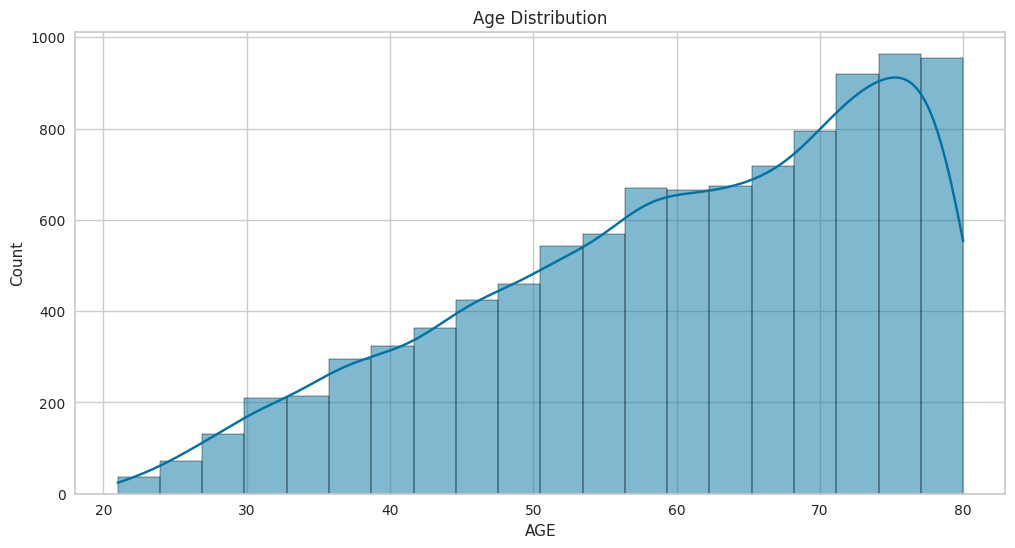

In [31]:
# Plotting distribution of age
from matplotlib import rcParams

# Configure the font family to avoid 'sans-serif' warnings
rcParams['font.family'] = 'DejaVu Sans'  # or another available font on your system

plt.figure(figsize=(12, 6))
sns.histplot(customer_df['AGE'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

In [32]:
# Checking for missing values
print(customer_df.isna().sum())

PLAYER_ID                                  0
DATE_FIRST_VISIT                           0
DATE_LAST_VISIT                            0
TOTAL_NUMBER_OF_VISITS                     0
TOTAL_DURATION_SPENT                       0
AVERAGE_DURATION_PER_VISIT                 0
TOTAL_CHIPS_WON_OR_LOST                    0
AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT        0
UNIQUE_GAMES_PLAYED                        0
IS_PREMIUM_PLAYER                          0
IS_LOYALTY_CARD_HOLDER                     0
TOTAL_AMOUNT_SPENT_IN_HOTEL                0
TOTAL_DAYS_SPENT_HOTEL                     0
TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT    0
NUMBER_OF_RESTAURANT_VISITS                0
TOTAL_AMOUNT_SPENT_IN_SPA                  0
NUMBER_OF_SPA_VISITS                       0
TOTAL_REVENUE_TO_CASINO                    0
NUMBER_OF_CONCIERGE_VISITS                 0
PREFERRED_GAME_CATEGORY                    0
PREFERRED_GAME_NAME                        0
AGE                                        0
GENDER    

In [33]:
# Fill missing values or drop them if appropriate
customer_df = customer_df.dropna()  # Here we simply drop missing values

ValueError: supplied range of [-30.0, inf] is not finite

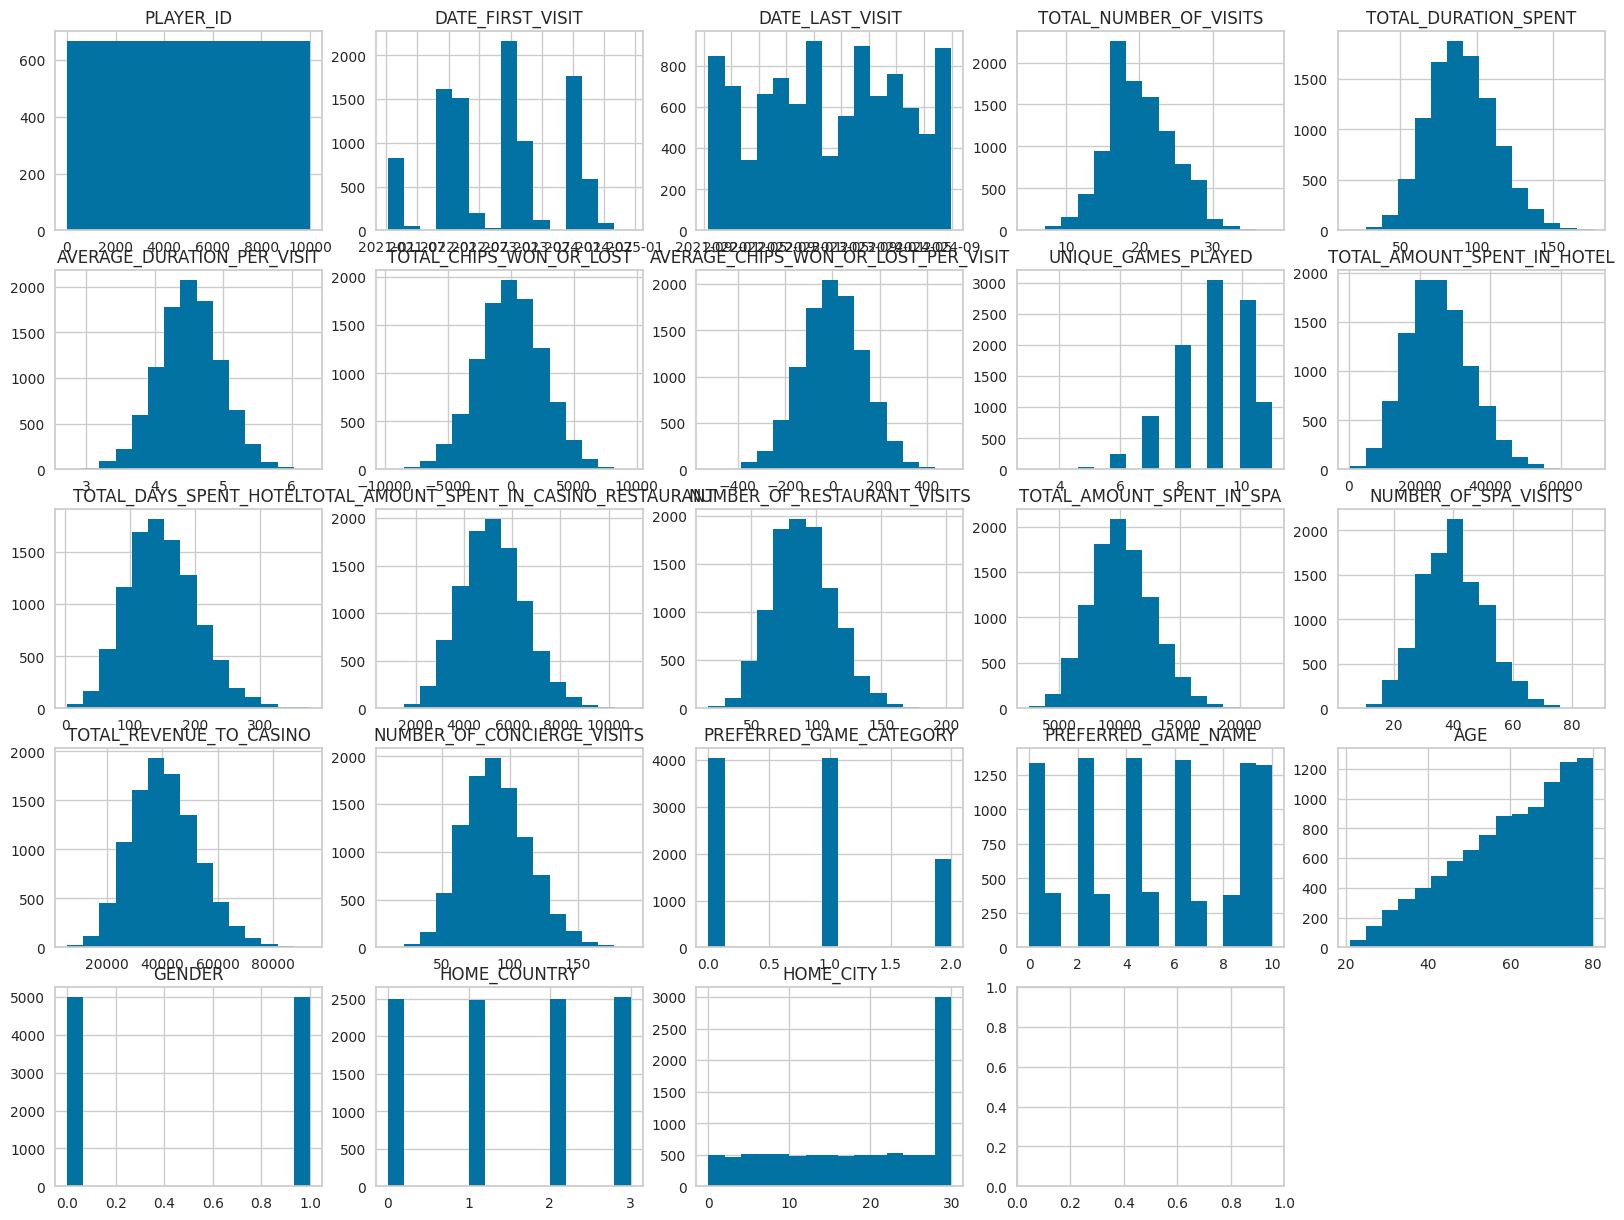

In [34]:
# Plotting distribution for numeric features in customer data
customer_df.hist(bins=15, figsize=(20, 15))
plt.suptitle('Distribution of Numeric Features in Customer Data')
plt.show()

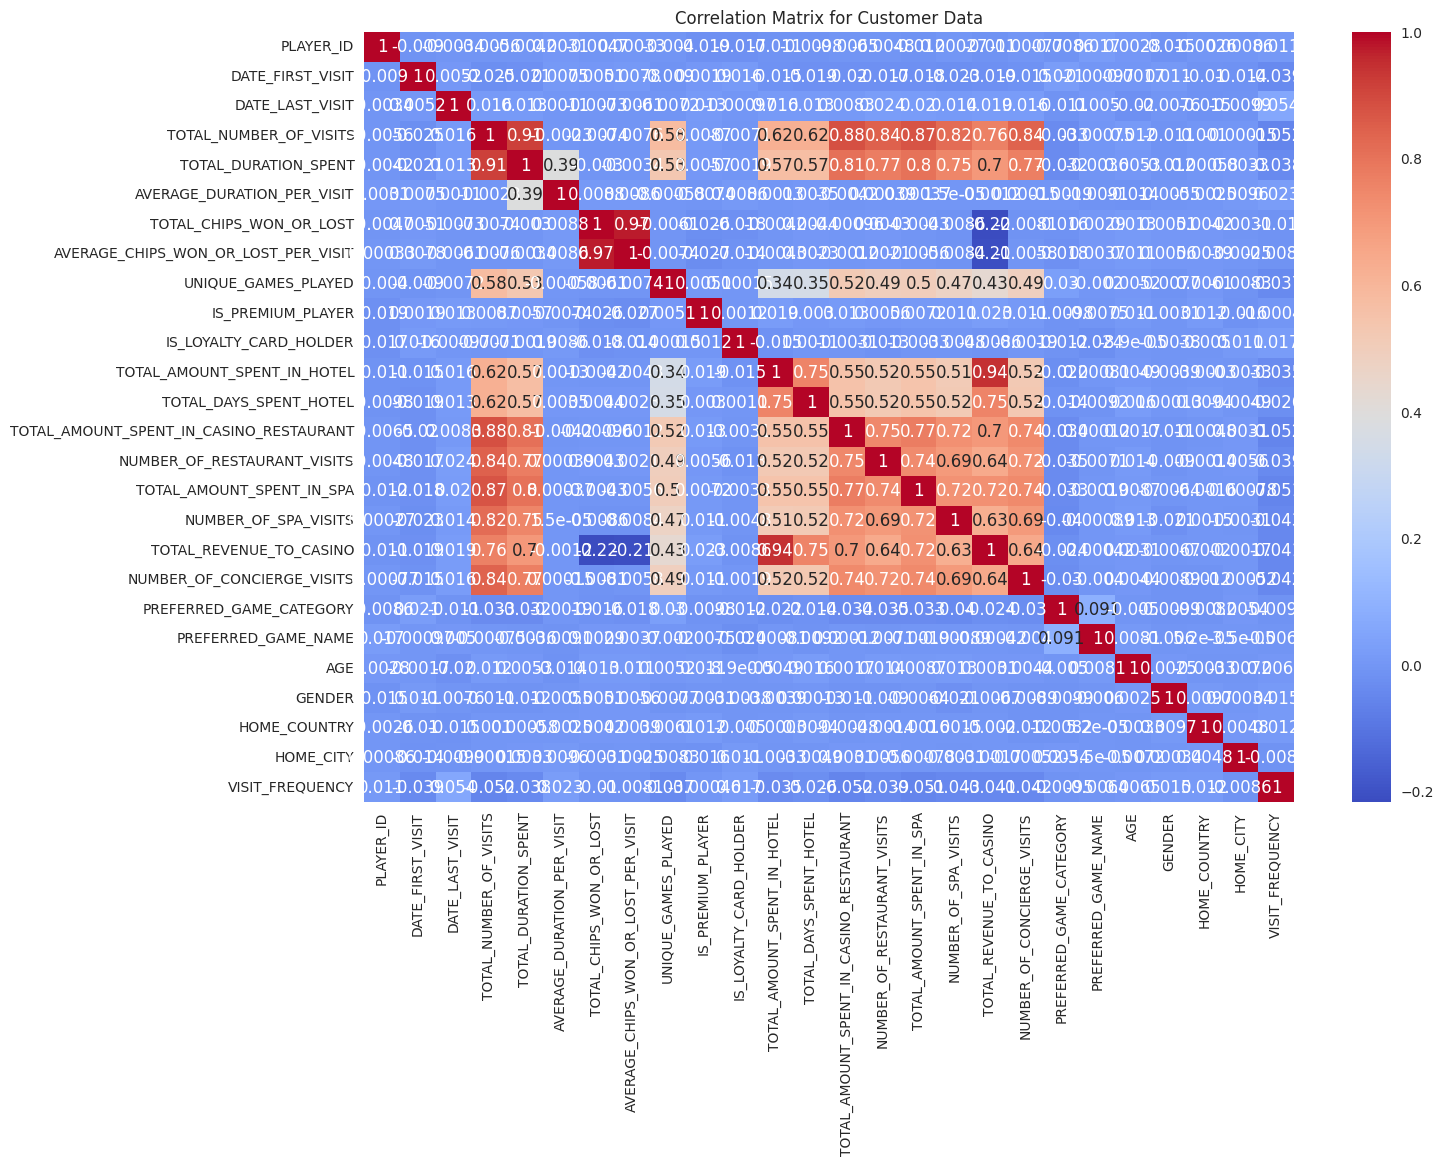

In [35]:
# Correlation matrix for customer_df
correlation_matrix = customer_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Customer Data')
plt.show()

<Axes: >

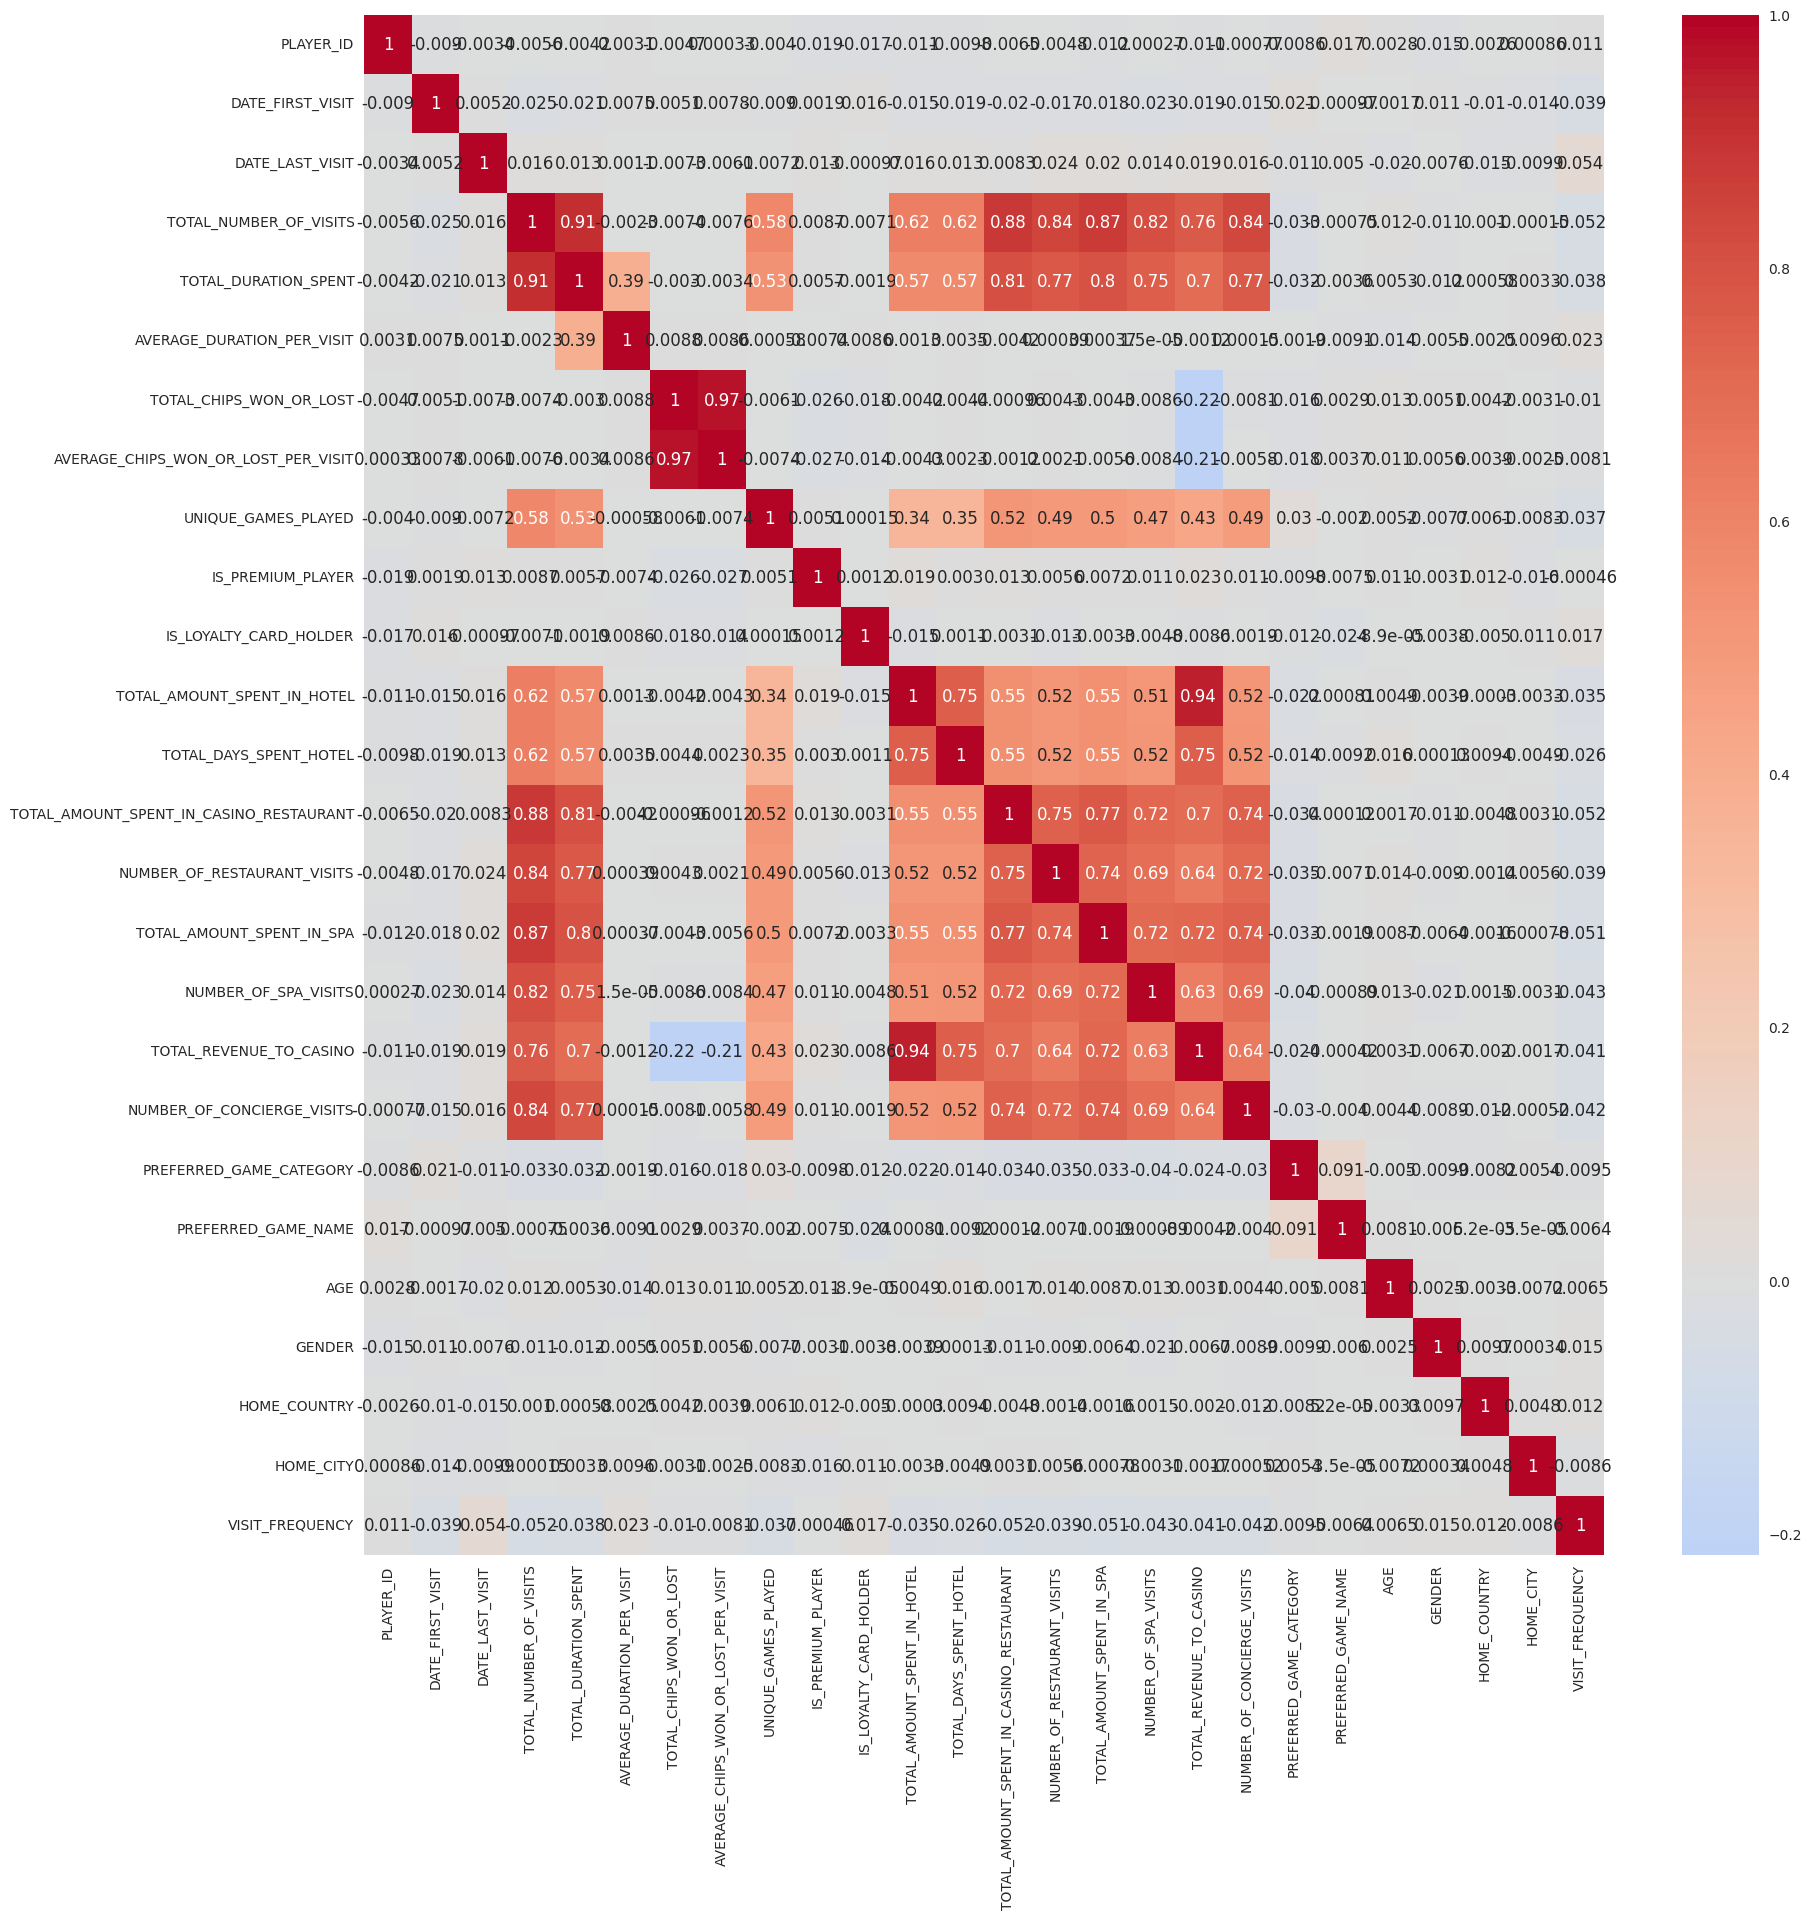

In [36]:

corrmat= customer_df.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap='coolwarm', center=0)

In [37]:
scaled_ds.head()

NameError: name 'scaled_ds' is not defined

In [38]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   PLAYER_ID                                10000 non-null  int64         
 1   DATE_FIRST_VISIT                         10000 non-null  datetime64[ns]
 2   DATE_LAST_VISIT                          10000 non-null  datetime64[ns]
 3   TOTAL_NUMBER_OF_VISITS                   10000 non-null  int64         
 4   TOTAL_DURATION_SPENT                     10000 non-null  float64       
 5   AVERAGE_DURATION_PER_VISIT               10000 non-null  float64       
 6   TOTAL_CHIPS_WON_OR_LOST                  10000 non-null  int64         
 7   AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT      10000 non-null  float64       
 8   UNIQUE_GAMES_PLAYED                      10000 non-null  int64         
 9   IS_PREMIUM_PLAYER                       

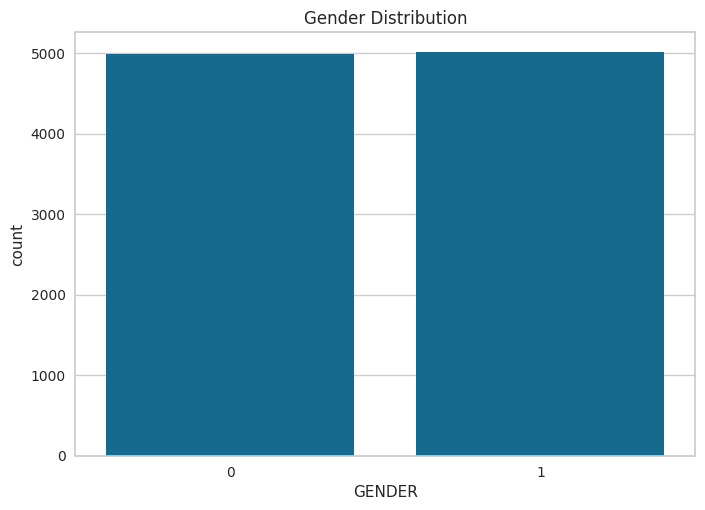

In [39]:
# Plotting categorical features against target variable
sns.countplot(x='GENDER', data=customer_df)
plt.title('Gender Distribution')
plt.show()

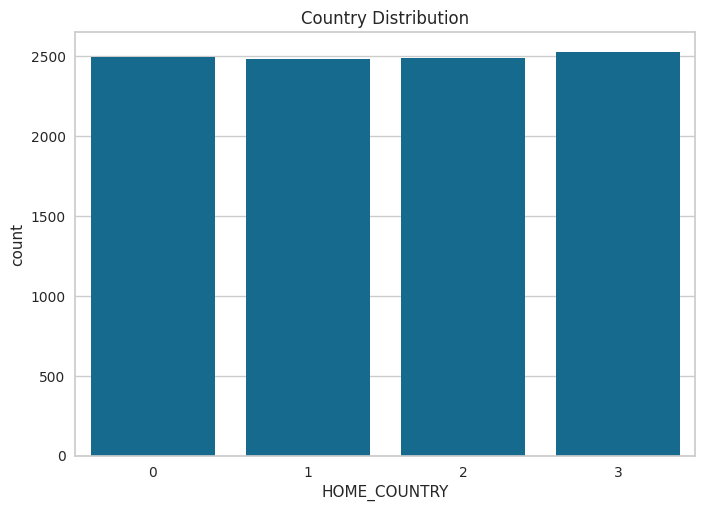

In [40]:
sns.countplot(x='HOME_COUNTRY', data=customer_df)
plt.title('Country Distribution')
plt.show()